IMPORT LIBRARY

In [1]:
import sys, os
current_dir = os.getcwd()
project_root = current_dir[:current_dir.find("src") - 1]
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger
from models import Random_Forest, Linear
from src.root import get_root

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

READ CSV

In [2]:
df_row = pd.read_csv(get_root() +"/data/processed/integrated.csv", encoding='utf-8')

feature_adder = Feature_adder(df_row)
feature_adder.add_season()

df_modified = df_row.copy(deep=True)

df_modified['date'] = pd.to_datetime(df_modified['date'])
df_modified['datetime'] = df_modified['date'] + pd.to_timedelta(df_row['hour'], unit='h')

functions

In [3]:
def filter_time(df,date1,date2,get_bool=False):
    if get_bool:
        return (df['datetime'] >= date1) & (df['datetime'] <= date2)
    return df[(df['datetime'] >= date1) & (df['datetime'] <= date2)]
def filter_name_code(df,name,code,get_bool=False):
    if get_bool:
        return (df["name"] == name) & (df["code"] == code)
    return df[(df["name"] == name) & (df["code"] == code)]

In [4]:
df_name_code = filter_name_code(df_modified,"پرند","G11")
df_smooth = Data_selector(df_name_code).select(m_in_summer=True)

In [5]:
def get_interval(df,l_min):
    df_s = df.reset_index(drop=True)
    diff = df_s['datetime'].diff()  # محاسبه اختلاف زمانی بین ردیف ها
    gap_mask = diff != pd.Timedelta(hours=1)  # هر جایی اختلاف دقیقاً 1 ساعت نیست، مرز بازه جدید است
    # ایندکس شروع بازه‌ها
    start_indices = df_s.index[gap_mask].tolist()
    # چون اولین ایندکس هم ابتدای یک بازه است، اگر نیست اضافه می‌کنیم
    if 0 not in start_indices:
        start_indices = [0] + start_indices
    # ایندکس پایان بازه‌ها یکی قبل از شروع بازه بعدی است
    end_indices = [i-1 for i in start_indices[1:]] + [df_s.index[-1]]
    
    for i in range(len(start_indices)-1,-1,-1):
        if end_indices[i] - start_indices[i] < l_min-1:
            end_indices.pop(i)
            start_indices.pop(i)
    # ساخت لیست بازه‌های (i1, i2)
    index_ranges = list(zip(start_indices, end_indices))
    
    # ساخت لیست بازه‌های زمانی (t1, t2)
    time_ranges = [(df_s.loc[i1, 'datetime'], df_s.loc[i2, 'datetime']) for i1, i2 in index_ranges]
    return index_ranges,time_ranges

In [6]:
index_ranges,time_ranges = get_interval(df_smooth,l_min=4)

In [7]:
len(time_ranges)

1080

انتخاب پیک ها - بررسی پشت هم بودن - بررسی نرم بودن - نمایش نرم ها و غیر نرم ها

In [8]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def is_smooth_array(data,threshold,f_show = False):
    x = data["datetime"].to_numpy()  # Your x-values
    y = data["generation"].to_numpy()  # Your y-values
    window_length = len(y) - 1 + len(y)%2  # window size, must be odd, adjust for your data
    
    polyorder = 2  # polynomial order
    y_smooth = savgol_filter(y, window_length=window_length, polyorder=polyorder)

    # Compute residual noise
    residuals = y - y_smooth
    noise_std = np.std(residuals)
    value = np.var(np.diff(y, n=1))#abs(y-y.mean())#residuals
    
    # Optional: Visualize
    if f_show:
        plt.plot(x, y, label='Raw data')
        plt.plot(x, y_smooth, label='Smoothed curve')
        plt.legend()
        plt.show()

    if noise_std < threshold:  # threshold is your chosen value for smoothness
        return noise_std,True,value
    else:
        return noise_std,False,value

def is_smooth(df,date1,date2,data_var,data_date,threshold,flag=False):
    slice = filter_time(df,date1,date2)[["hour","generation","datetime"]]
    if len(slice["hour"]) >= 8:
        x,f,re = is_smooth_array(slice,threshold,flag)
        if data_var != None : data_var[f].append(x)
        if data_date != None : data_date[f].append((date1,date2))
        if f:    
            return 1,1
        return 1,0
    return 0,0

def get_smooth_good_slice(df,time_ranges,threshold):
    data_var = {True:[],False:[]}
    data_date = {True:[],False:[]}
    t = 0
    n = 0
    for date1,date2 in time_ranges:
        nn,tt = is_smooth(df,date1,date2,data_var,data_date,threshold)
        n += nn
        t += tt
    return t/n*100,data_var,data_date

In [9]:
threshold = 2
p,data_var,data_date = get_smooth_good_slice(df=df_smooth,time_ranges=time_ranges,threshold=threshold)
p

56.403269754768395

In [10]:
def get_sample(k,data_var,data_date):
    data_var = np.array(data_var)
    data_date = np.array(data_date)
    k_largest = data_var.argsort()[-k:]
    for date1,date2 in data_date[k_largest]:
        is_smooth(df_smooth,date1,date2,None,None,threshold=threshold,flag=True)

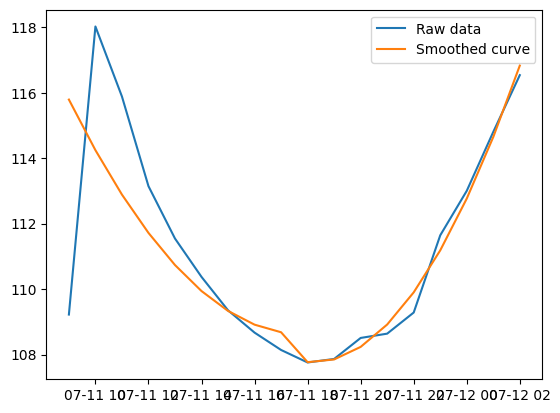

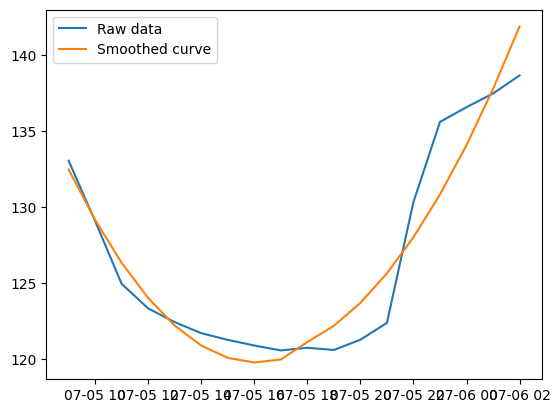

In [11]:
k = 2
get_sample(k,data_var[True],data_date[True])

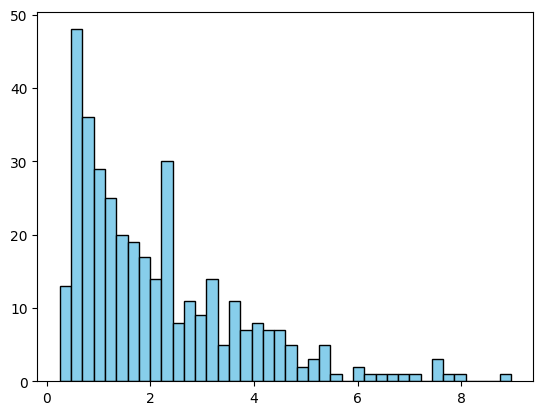

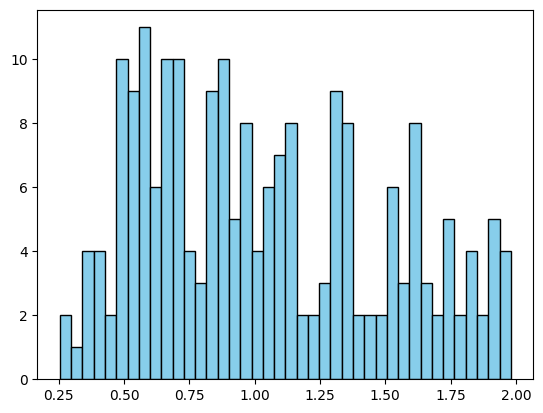

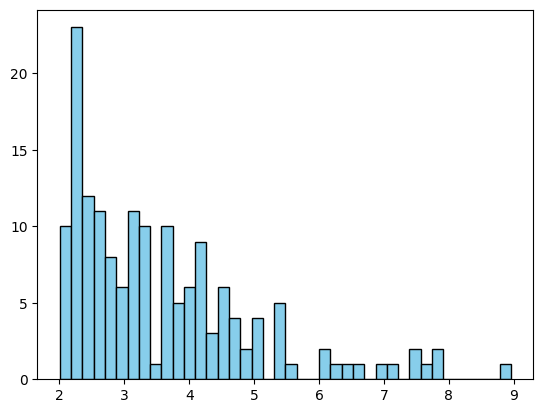

In [12]:
plt.hist(data_var[True]+data_var[False], bins=40, color='skyblue', edgecolor='black')
plt.show()
plt.hist(data_var[True], bins=40, color='skyblue', edgecolor='black')
plt.show()
plt.hist(data_var[False], bins=40, color='skyblue', edgecolor='black')
plt.show()

In [77]:
def labeling_point(df,df_n_c,date,label):
    for date1,date2 in date:
        flag_array = filter_time(df_n_c,date1,date2,get_bool=True)
        df.loc[flag_array.index[flag_array],"is_good_pick"] = label

In [ ]:
df_only = pd.read_csv(get_root() +'/data/processed/integrated.csv', encoding='utf-8')
df_only['datetime'] = pd.to_datetime(df_only['date']) + pd.to_timedelta(df_only['hour'], unit='h')
df_only['datetime'] = pd.to_datetime(df_only['datetime']) 
       
df_name_code = filter_name_code(df_only,"پرند","G11")

df_only["is_good_pick"] = 0
labeling_point(df_only,df_name_code,data_date[False],label=1)
labeling_point(df_only,df_name_code,data_date[True],label=2)
        

In [86]:
print(np.count_nonzero(df_only["is_good_pick"].to_numpy() == 2))

3722


In [88]:
print(len(data_date[False]),len(data_date[True]))
print(sum((m2-m1).total_seconds()/3600+1 for (m1,m2) in data_date[True]))
print(sum((m2-m1).total_seconds()/3600+1 for (m1,m2) in data_date[False]))

160 207
3722.0
2876.0


In [82]:
df_only.to_csv(path_or_buf=get_root() +'/data/processed/prediction_only.csv', sep=',', header=True, index=False,na_rep='NULL')

Find Match

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def dot_vectors(pick_df,tmep_df):
    a1 = pick_df.to_numpy()
    a2 = tmep_df.to_numpy()
    lv = []
    m1 = np.mean(a1)
    n1 = len(a1)
    n2 = len(a2)
    for i in range(0,n2-n1):
        m2 = np.mean(a2[-(i+1):-(i+n1):-1])
        lv.append(sum(  (a1[-(k+1)]-m1)  *  (a2[-(i+k+1)]-m2) for k in range(n1)))
    return np.array(lv)

def get_dphase(df,t1s,t2s,flag=False):
    t1 = pd.to_datetime(t1s)
    t2 = pd.to_datetime(t2s)
    t0 = t1 - np.timedelta64(12,'h')
    pick_df = filter_time(df,t1,t2)["generation"]
    tmep_df = filter_time(df,t0,t2)["temperature"]
    n = len(tmep_df)-len(pick_df)
    lv = dot_vectors(pick_df,tmep_df)
    
    time = np.arange(0,n)
    if flag:
        plt.plot(time,lv)
        plt.show()
    return lv

def get_for_alltime(df,times_pick): 
    d_get_dphase = []
    for s1,s2 in times_pick:
        d_get_dphase.append(get_dphase(df,s1,s2).argmin())#(s1,s2)
    return d_get_dphase

In [ ]:
times_pick = [(date + np.timedelta64(14,'h'),date + np.timedelta64(22,'h') ) for date in df_name_code["date"].unique()]
d_get_dphase = get_for_alltime(df_name_code,times_pick)

In [ ]:
a,b = np.unique(np.array(d_get_dphase), return_counts=True)
for i in range(len(a)):
   print(a[i],b[i])

0 252
1 160
2 255
3 235
4 142
5 72
6 31
7 12
8 10
9 19
10 48
11 224
35 1
